In [90]:
data_file = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/create_order_v1/experiment2/ato_order_create_v1_exp2_feature_1658805020411.txt'
venture = 'ID'

# impute null value
features_to_impute = [
    'freq_myacct',
    'freq_searchlist',
    'freq_pdp',
    'freq_acctinfo',
    'avg_stay_time_pdp',
    'total_stay_time_pdp',
    'avg_stay_time',
    'total_stay_time',
    'click_path_length',
    'id_susp_payment',
    'id_category_dg',
    'no_acct_same_umid_3m',
    'no_login_same_umid_3m'
]

# statistical features
stats = [
    'freq_myacct',
    'freq_searchlist',
    'freq_pdp',
    'freq_acctinfo',
    'avg_stay_time_pdp',
    'total_stay_time_pdp',
    'avg_stay_time',
    'total_stay_time',
    'click_path_length',
    'id_susp_payment',
    'id_category_dg',
    'no_acct_same_umid_3m',
    'no_login_same_umid_3m'
]

# for EDA
types = [
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    True,
    True,
    False,
    False
]

# Import Packages

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

# Main Code

## 1. Load data and Black Samples Percentage

In [103]:
# load data
df = pd.read_csv(data_file, delimiter = ',', dtype = str)
df['label'] = df['label'].astype(float)

# Calculate percent of black samples
bl_cnt = (df.label==1).astype(float).sum()
total = (df.label!=-1).astype(float).sum()
percent = round((bl_cnt / total)*100, 2)

print(bl_cnt, 'black samples out of a total of', total, 'samples.')
print('Black sample percent: ' +  str(percent) + '%')

1086.0 black samples out of a total of 11991.0 samples.
Black sample percent: 9.06%


In [104]:
df.head(3)

,label,order_buyer_id,orderid,order_create_time,features,spam_list,freq_myacct,freq_searchlist,freq_pdp,freq_acctinfo,avg_stay_time_pdp,total_stay_time_pdp,avg_stay_time,total_stay_time,click_path_length,id_susp_payment,id_category_dg,no_acct_same_umid_3m,no_login_same_umid_3m
0,1.0,7764073,834847830364073,2022-04-08 23:11:33,"member_mobile_existed,member_myaccount,home,22...","[""member_mobile_existed"",""member_myaccount"",""h...",0.12631578947368421,0.021052631578947368,0.021052631578947368,0.010526315789473684,17.976,35.952,16.69888421052632,1586.3940000000002,95,0,1,32,1
1,1.0,10220757,829907860020757,2022-04-03 15:36:12,"22609283,search,home,member_myaccount,msgtabs_...","[""22609283"",""search"",""home"",""member_myaccount""...",0.1409090909090909,0.022727272727272728,0.04090909090909091,0.0,8.056666666666667,72.51,11.952150000000001,2629.4730000000004,220,1,0,25,2
2,1.0,10434347,832036467634347,2022-04-05 20:27:54,"member_mobile_existed,member_myaccount,2260928...","[""member_mobile_existed"",""member_myaccount"",""2...",0.10294117647058823,0.04411764705882353,0.09558823529411764,0.014705882352941176,3.768461538461538,48.989999999999995,6.534272058823526,888.6609999999996,136,0,1,3,1


## 2. kick out 'null' click-path and impute other statistical features with 0

In [105]:
# Check if any columns contain null
print('Column with Nulls:')
print(df.isnull().sum()[df.isnull().sum() != 0])

Column with Nulls:
features    1
dtype: int64


In [106]:
print(df.isnull().sum(axis=1)[df.isnull().sum(axis=1) != 0])

11539    1
dtype: int64


In [107]:
# impute null values
# replace null value with 0
df = df.replace('\\N', 0)
df[features_to_impute] = df[features_to_impute].astype(float)

In [108]:
effective_index = list(range(0, 11539)) + list(range(11540,11991))
df = df.iloc[effective_index]
df.reset_index(drop=True,inplace=True)

In [109]:
# Check if any columns contain null
print('Column with Nulls:')
print(df.isnull().sum()[df.isnull().sum() != 0])

Column with Nulls:
Series([], dtype: int64)


## 3. Load Sentence-Transformer Model and Calculate Click-path Embedding

In [50]:
multi_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [51]:
pool = multi_model.start_multi_process_pool()

In [52]:
X = multi_model.encode_multi_process(df.features.to_list(), pool)

In [113]:
y = np.array(df.label.to_list())

(11990,)

## 4. EDA

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
def display_kdeplot(df, col1, col2, is_cat):
    df[col1] = df[col1].astype(float)
    plt.figure(figsize = (15, 6))
    if is_cat:
        sns.countplot(data = df, x = col1, hue = col2)
    else:
        ax = plt.axes()
        sns.kdeplot(data = df[df[col2] == 0], x = col1, color = 'darkorange', label = 'Non-ATO')
        ax_bis = ax.twinx()
        sns.kdeplot(data = df[df[col2] == 1], x = col1, label = 'ATO')
        plt.title(col1)
        ax.legend(loc = 'upper left')
        ax_bis.legend(loc = 'upper right')
        # ax.set_xscale('log')
    plt.show()
    
    print(df.groupby(col2)[col1].describe())
    print(col1)

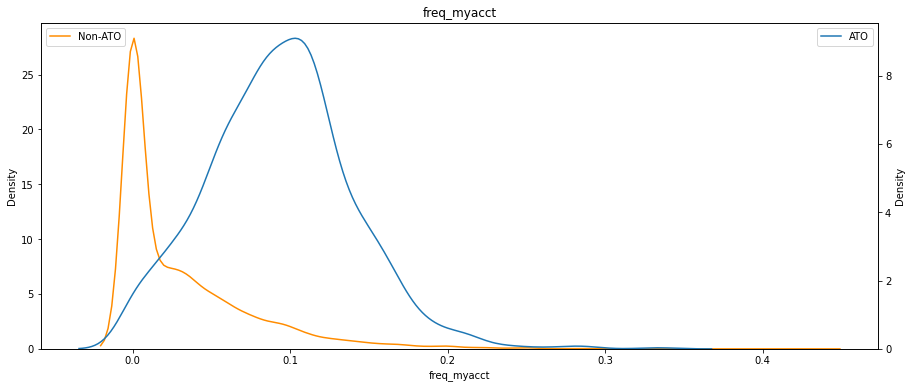

         count      mean       std  min       25%       50%       75%  \
label                                                                   
0.0    10904.0  0.030873  0.043739  0.0  0.000000  0.011636  0.048544   
1.0     1086.0  0.093100  0.046104  0.0  0.062116  0.093023  0.119300   

            max  
label            
0.0    0.428571  
1.0    0.333333  
freq_myacct
------------------------------------------------------------------------


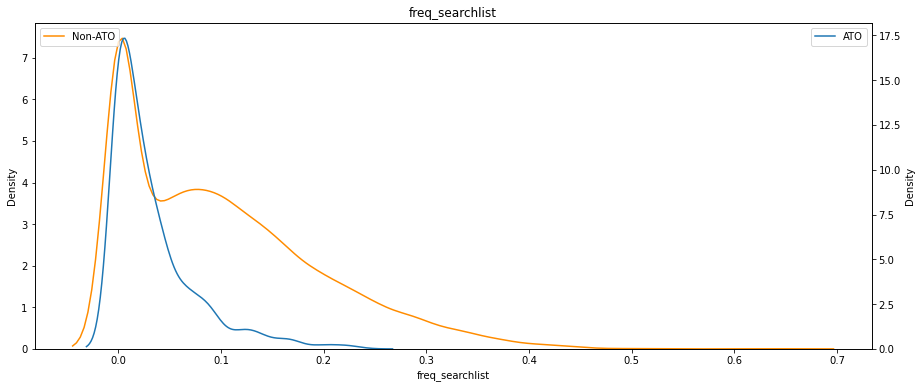

         count      mean       std  min       25%       50%       75%  \
label                                                                   
0.0    10904.0  0.100388  0.095145  0.0  0.010687  0.082599  0.156721   
1.0     1086.0  0.033154  0.041840  0.0  0.000000  0.019540  0.045020   

            max  
label            
0.0    0.652174  
1.0    0.236111  
freq_searchlist
------------------------------------------------------------------------


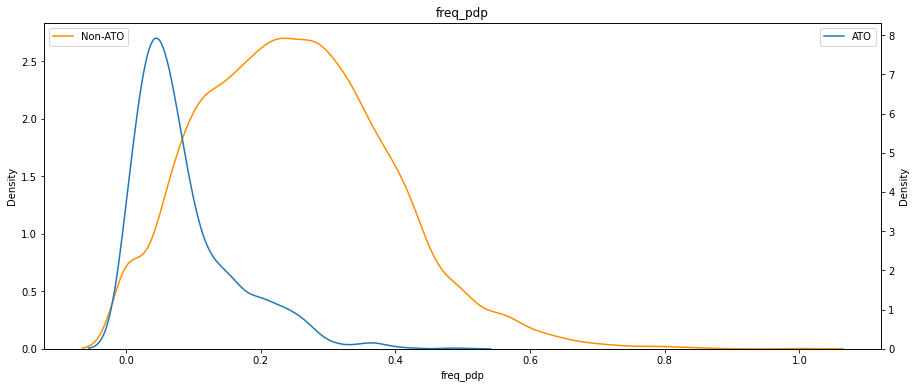

         count      mean       std  min       25%       50%       75%  \
label                                                                   
0.0    10904.0  0.252426  0.138715  0.0  0.148892  0.246193  0.341880   
1.0     1086.0  0.085932  0.074782  0.0  0.033563  0.063165  0.117469   

            max  
label            
0.0    1.000000  
1.0    0.486111  
freq_pdp
------------------------------------------------------------------------


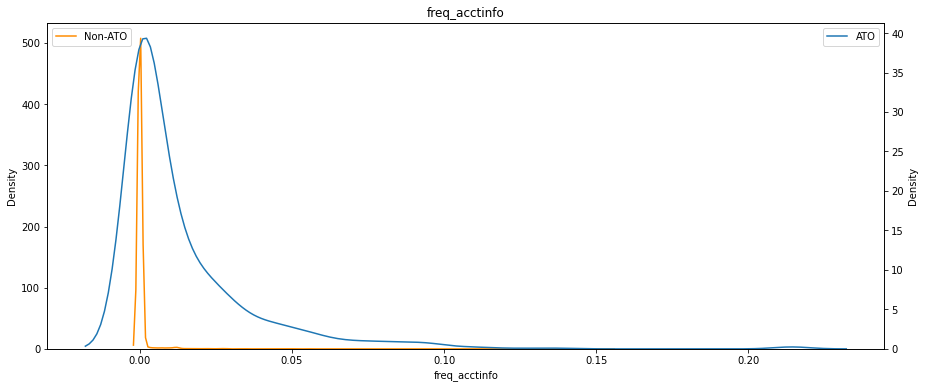

         count      mean       std  min  25%       50%       75%       max
label                                                                     
0.0    10904.0  0.000526  0.004496  0.0  0.0  0.000000  0.000000  0.153846
1.0     1086.0  0.013882  0.024145  0.0  0.0  0.003867  0.018976  0.214286
freq_acctinfo
------------------------------------------------------------------------


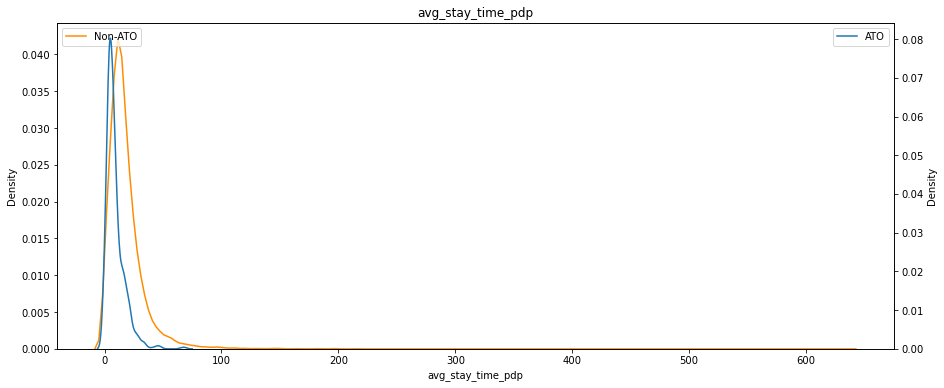

         count       mean        std  min       25%        50%        75%  \
label                                                                       
0.0    10904.0  18.054413  17.494783  0.0  8.763177  14.354222  22.480162   
1.0     1086.0   9.002111   7.952380  0.0  3.917852   6.746244  11.498792   

           max  
label           
0.0    634.349  
1.0     69.109  
avg_stay_time_pdp
------------------------------------------------------------------------


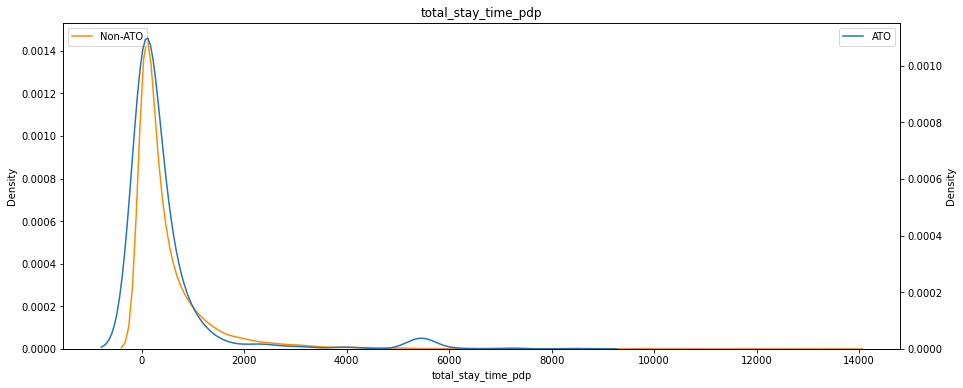

         count       mean          std  min       25%      50%        75%  \
label                                                                       
0.0    10904.0  522.81848   851.202696  0.0  65.26200  232.104  621.00200   
1.0     1086.0  463.73207  1060.244377  0.0  26.73025  101.333  437.71175   

             max  
label             
0.0    13662.066  
1.0     8482.330  
total_stay_time_pdp
------------------------------------------------------------------------


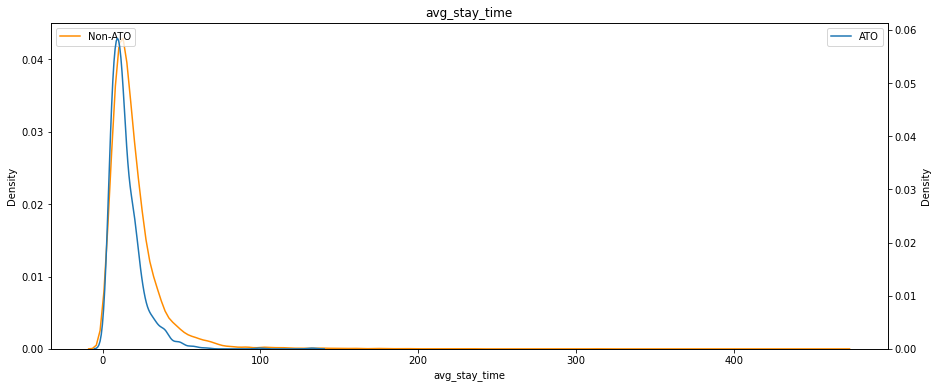

         count       mean        std    min        25%        50%        75%  \
label                                                                          
0.0    10904.0  20.408433  19.179838  0.113  10.191422  15.737205  24.309213   
1.0     1086.0  14.703653  10.389700  2.465   7.874231  12.065417  18.780610   

              max  
label              
0.0    464.218727  
1.0    132.737516  
avg_stay_time
------------------------------------------------------------------------


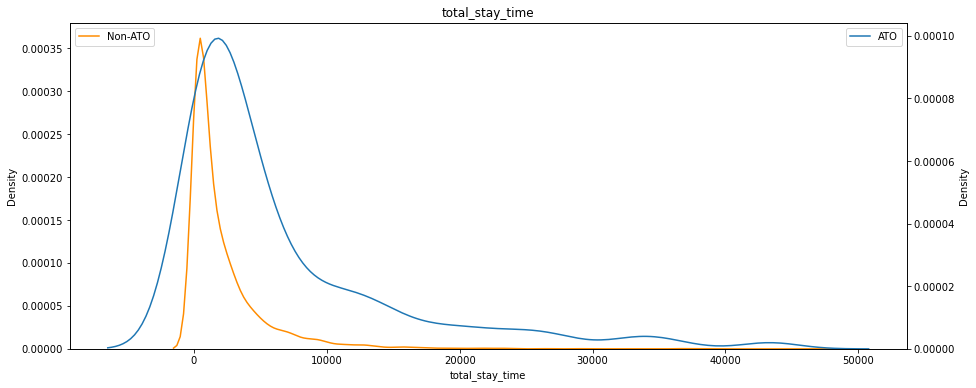

         count         mean          std     min       25%        50%  \
label                                                                   
0.0    10904.0  2245.787501  3302.975330   0.113  351.8445  1033.0475   
1.0     1086.0  6682.846825  8783.966476  15.824  963.7010  3196.4920   

              75%        max  
label                         
0.0    2789.79375  46961.390  
1.0    8547.66725  44273.021  
total_stay_time
------------------------------------------------------------------------


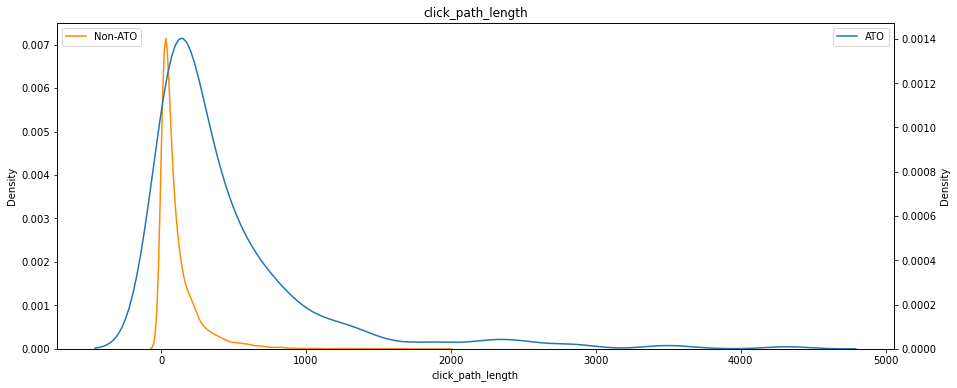

         count        mean         std  min    25%    50%     75%     max
label                                                                    
0.0    10904.0  116.915994  155.518713  1.0  27.00   62.0  144.00  1938.0
1.0     1086.0  456.523020  619.678605  3.0  89.25  238.5  564.75  4336.0
click_path_length
------------------------------------------------------------------------


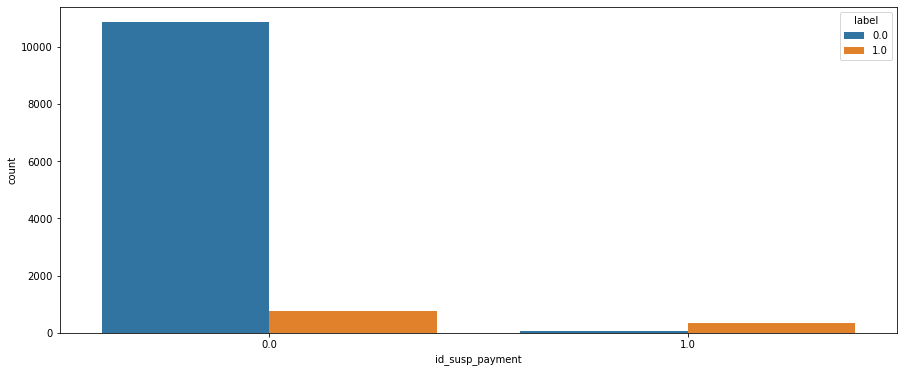

         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    10904.0  0.005044  0.070845  0.0  0.0  0.0  0.0  1.0
1.0     1086.0  0.303867  0.460138  0.0  0.0  0.0  1.0  1.0
id_susp_payment
------------------------------------------------------------------------


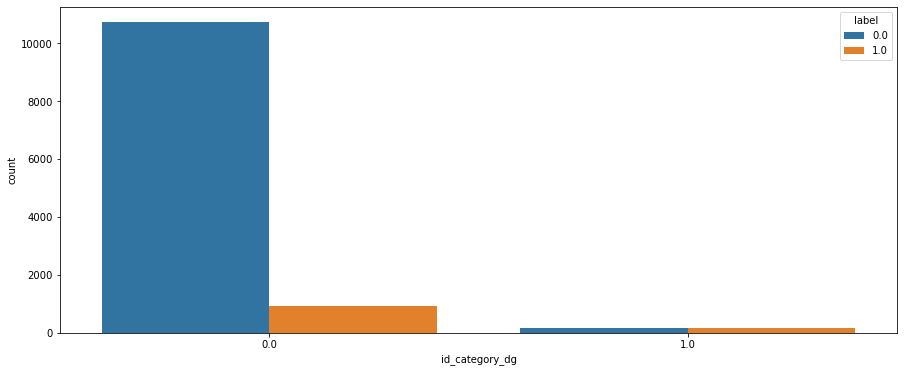

         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    10904.0  0.017058  0.129493  0.0  0.0  0.0  0.0  1.0
1.0     1086.0  0.142726  0.349954  0.0  0.0  0.0  0.0  1.0
id_category_dg
------------------------------------------------------------------------


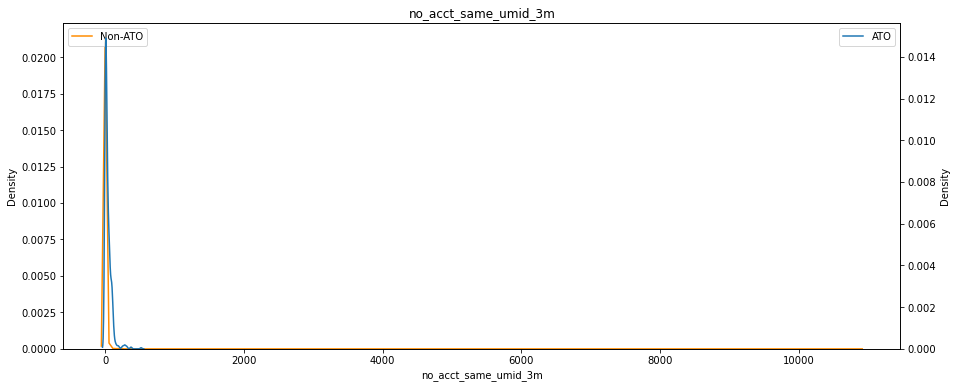

         count       mean         std  min  25%   50%   75%      max
label                                                               
0.0    10904.0   4.017241  118.001183  0.0  1.0   1.0   1.0  10857.0
1.0     1086.0  39.409761   53.278216  1.0  4.0  22.0  58.0    517.0
no_acct_same_umid_3m
------------------------------------------------------------------------


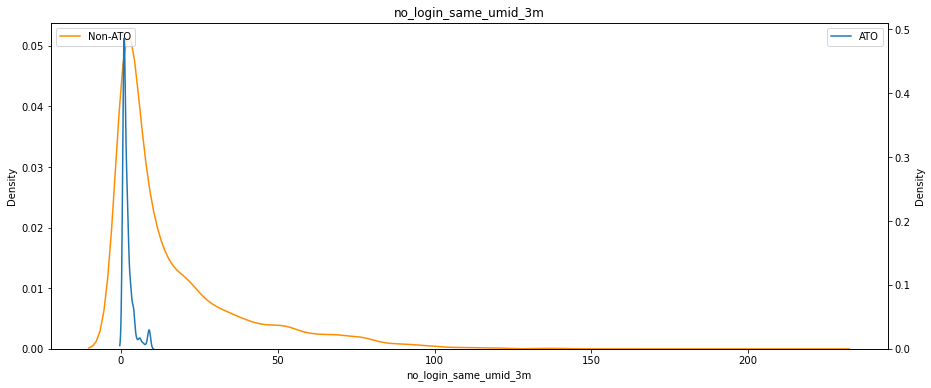

         count       mean        std  min  25%  50%   75%    max
label                                                           
0.0    10904.0  17.131878  22.022327  0.0  2.0  8.0  24.0  222.0
1.0     1086.0   2.118785   1.821954  1.0  1.0  1.0   2.0    9.0
no_login_same_umid_3m
------------------------------------------------------------------------


In [99]:
for i in range(len(stats)):
    feature_name = stats[i]
    feature_type = types[i]
    display_kdeplot(df, feature_name, 'label', feature_type)
    print('------------------------------------------------------------------------')

### Normalisation

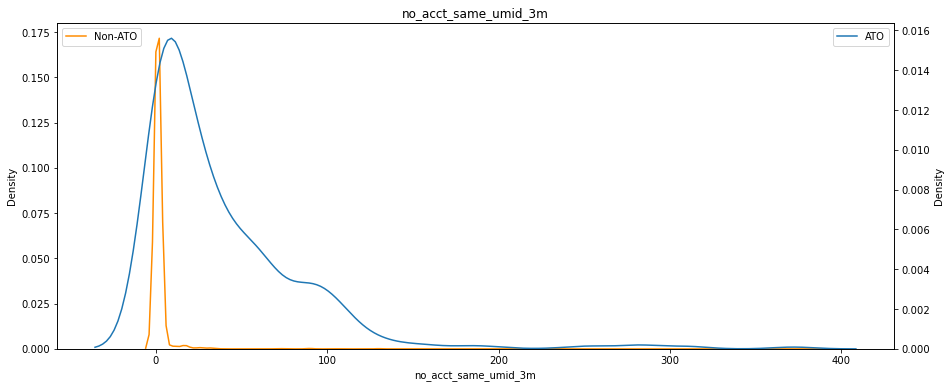

         count       mean        std  min  25%   50%   75%    max
label                                                            
0.0    10904.0   2.502018  12.598885  0.0  1.0   1.0   1.0  383.0
1.0     1086.0  38.476059  49.181736  1.0  4.0  22.0  58.0  372.0
no_acct_same_umid_3m


In [101]:
def normalize(num):
    if num >= 500:
        return 10
    else: 
        return num
df_modify = df
df_modify['no_acct_same_umid_3m'] = df['no_acct_same_umid_3m'].apply(normalize)

display_kdeplot(df_modify, 'no_acct_same_umid_3m', 'label', False)

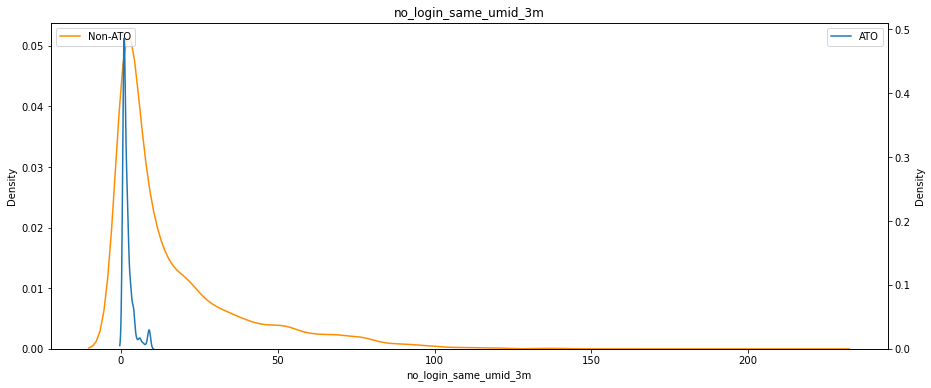

         count       mean        std  min  25%  50%   75%    max
label                                                           
0.0    10904.0  17.131878  22.022327  0.0  2.0  8.0  24.0  222.0
1.0     1086.0   2.118785   1.821954  1.0  1.0  1.0   2.0    9.0
no_login_same_umid_3m


In [102]:
df_modify['no_login_same_umid_3m'] = df['no_login_same_umid_3m'].apply(normalize)

display_kdeplot(df_modify, 'no_login_same_umid_3m', 'label', False)

## 5. Model training

In [114]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold

In [1]:
# given the dataset/label, classifier
## return the prediction for the whole dataset and confusion matrix
def run_exp(X, y, model, model_name, notation):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    acc = []
    df[model_name + notation] = -1
    for train_index, test_index in skf.split(X, y):
#         print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
#         import pdb; pdb.set_trace()
        df.loc[test_index, model_name + notation] = y_pred
        acc.append(accuracy_score(y_test, y_pred))
#     print(f'{model_name}: acc: {np.mean(acc)}, +/-, {np.std(acc)}')
    target_names = ['class 0', 'class 1']
    print(classification_report(df.label, df[model_name + notation], target_names=target_names))
    print(confusion_matrix(df.label, df[model_name + notation]))
#     cv_results = cross_validate(model, X, y, cv=cv)
#     print(cv_results['test_score'])

In [116]:
X_stats = np.concatenate([X, df[stats].to_numpy()], axis=1)

### Click path + Statistical features

In [117]:
model = RandomForestClassifier()
run_exp(X_stats, y, model, type(model).__name__, 'features_exp2')

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99     10904
     class 1       0.99      0.90      0.94      1086

    accuracy                           0.99     11990
   macro avg       0.99      0.95      0.97     11990
weighted avg       0.99      0.99      0.99     11990

[[10897     7]
 [  109   977]]


### statistical featuers only

In [118]:
model = RandomForestClassifier()
run_exp(df[stats].to_numpy(), y, model, type(model).__name__, 'stat_featuers_exp2')

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99     10904
     class 1       0.97      0.87      0.92      1086

    accuracy                           0.99     11990
   macro avg       0.98      0.94      0.96     11990
weighted avg       0.99      0.99      0.99     11990

[[10879    25]
 [  136   950]]


In [67]:
X_stats.shape

(11990, 525)